In [2]:
import time
import argparse
from tqdm import tqdm

import pandas as pd

import torch
from torch.utils.data import DataLoader
import models
from torchvision.transforms import *

from datasets import *
from transforms import *

from utils import rlenc, rlenc_np, FasterRle, gzip_save

/wgdisk/st0008/hzh/workspace/tgs/venv_pytorch_saltnet/venv_pytorch_saltnet/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
orig_img_size = 101
img_size = 128
padding = compute_padding(orig_img_size, orig_img_size, img_size)
d_y0, d_y1, d_x0, d_x1 = padding
y0, y1, x0, x1 = d_y0, d_y0 + orig_img_size, d_x0, d_x0 + orig_img_size

In [4]:
y0, y1, x0, x1

(13, 114, 13, 114)

In [5]:
def predict(args, model, batch, flipped_batch, use_gpu):
    
    image_ids, inputs = batch['image_id'], batch['input']
    if use_gpu:
        inputs = inputs.cuda()
        
    # predict original data
    outputs, _, _ = model(inputs)
    probs = torch.sigmoid(outputs)

    if flipped_batch is not None:
        flipped_image_ids, flipped_inputs = flipped_batch['image_id'], flipped_batch['input']
        # assert image_ids == flipped_image_ids
        if use_gpu:
            flipped_inputs = flipped_inputs.cuda()
            
        # predict flipped data
        flipped_outputs, _, _ = model(flipped_inputs)
        flipped_probs = torch.sigmoid(flipped_outputs)

        probs += torch.flip(flipped_probs, (3,))  # flip back and add
        probs *= 0.5

    probs = probs.squeeze(1).cpu().numpy()    # squeeze channel dimension
    if args.resize:
        probs = np.swapaxes(probs, 0, 2)
        # using opencv-python
        import cv2
        probs = cv2.resize(probs, (orig_img_size, orig_img_size), interpolation=cv2.INTER_LINEAR)
#         from skimage.transform import resize
#         probs = resize(probs, (orig_img_size, orig_img_size) )
        probs = np.swapaxes(probs, 0, 2)
    else:
        probs = probs[:, y0:y1, x0:x1]

    return probs

In [6]:
def test(args):
    # test dataset
    test_transform = Compose([PrepareImageAndMask(),
                              ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    test_dataset = SaltIdentification(mode='test', transform=test_transform, preload=False)
    test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, num_workers=args.dataload_workers_nums)

    # flipped test dataset
    flipped_test_transform = Compose([PrepareImageAndMask(), HorizontalFlip(),
                                      ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    flipped_test_dataset = SaltIdentification(mode='test', transform=flipped_test_transform, preload=False)
    flipped_test_dataloader_iter = iter(DataLoader(flipped_test_dataset, batch_size=args.batch_size,
                                                   num_workers=args.dataload_workers_nums))

    model.eval()
    torch.set_grad_enabled(False)

    prediction = {}
    submission = {}
    #pbar = tqdm(test_dataloader, unit="images", unit_scale=test_dataloader.batch_size, disable=None)
    pbar = tqdm(test_dataloader, unit=" images", unit_scale=test_dataloader.batch_size)

    empty_images_count = 0
    for batch in pbar:
        
        image_ids = batch['image_id']

        if args.tta:
            flipped_batch = next(flipped_test_dataloader_iter)
        else:
            flipped_batch = None

        probs = predict(args, model, batch, flipped_batch, use_gpu=use_gpu)
        
        # prediction
        pred = probs > args.threshold
        
        # submission of pred
        rle = rlenc_np(pred)
        submission.update(dict(zip(image_ids, rle)))

        empty_images_count += (pred.sum(axis=(1, 2)) == 0).sum()

        # probabilities
        probs_uint16 = (65535 * probs).astype(dtype=np.uint16)
        prediction.update(dict(zip(image_ids, probs_uint16)))
            
    empty_images_percentage = empty_images_count / len(prediction)
    print("empty images: %.2f%% (in public LB 38%%)" % (100 * empty_images_percentage))

    # probabilities
    gzip_save('-'.join([args.output_prefix, 'probabilities.pkl.gz']), prediction)
    
    # submission
    sub = pd.DataFrame.from_dict(submission, orient='index')
    sub.index.names = ['id']
    sub.columns = ['rle_mask']
    sub.to_csv('-'.join([args.output_prefix, 'submission.csv']))

In [7]:
def qc_test(args):
    """ for testing a small dataset """

    # test dataset
    test_transform = Compose([PrepareImageAndMask(),
                              ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    test_dataset = SaltIdentification(mode='test', transform=test_transform, preload=False)
    
    # random indices
    indices = np.random.choice( len(test_dataset), args.batch_size)
    print(f'indices: {indices}')
    
    # picked test dataset
    test_dataset0 = torch.utils.data.Subset(test_dataset, indices)
    
    test_dataloader = DataLoader(test_dataset0, batch_size=args.batch_size, num_workers=args.dataload_workers_nums)
    test_dataloader_iter = iter(test_dataloader)

    # flipped test dataset
    flipped_test_transform = Compose([PrepareImageAndMask(), HorizontalFlip(),
                                      ResizeToNxN(img_size) if args.resize else PadToNxN(img_size), HWCtoCHW()])
    flipped_test_dataset = SaltIdentification(mode='test', transform=flipped_test_transform, preload=False)
    
    # for flipped test dataset
    flipped_test_dataset0 = torch.utils.data.Subset(flipped_test_dataset, indices)
    
    flipped_test_dataloader_iter = iter(DataLoader(flipped_test_dataset0, batch_size=args.batch_size,
                                                   num_workers=args.dataload_workers_nums))

    model.eval()
    torch.set_grad_enabled(False)
    
    # test data
    batch = next(test_dataloader_iter)
    
    image_ids = batch['image_id']
    images = batch['input']

    # flipped data
    if args.tta:
        flipped_batch = next(flipped_test_dataloader_iter)
    else:
        flipped_batch = None

    # predicted probabilities
    probs = predict(args, model, batch, flipped_batch, use_gpu=use_gpu)

    # prediction
    pred = np.zeros_like(probs)
    pred[probs > args.threshold] = 1

    # output probabilities
    probs_uint16 = (65535 * probs).astype(dtype=np.uint16)

    # input images
    image_samples = images[:, :, y0:y1, x0:x1].permute(0, 2, 3, 1).numpy()
        
    return image_ids, pred, probs_uint16, image_samples


In [8]:
parser = argparse.ArgumentParser(description=__doc__, formatter_class=argparse.ArgumentDefaultsHelpFormatter)
parser.add_argument("--batch-size", type=int, default=30, help='batch size')
parser.add_argument("--dataload-workers-nums", type=int, default=8, help='number of workers for dataloader')
parser.add_argument('--tta', action='store_true', help='test time augmentation')
parser.add_argument('--seed', type=int, default=None, help='manual seed for deterministic')
parser.add_argument("--threshold", type=float, default=0.5, help='probability threshold')
parser.add_argument("--output-prefix", type=str, default='noprefix', help='prefix string for output files')
parser.add_argument('--resize', action='store_true', help='resize to 128x128 instead of reflective padding')
parser.add_argument("model", help='a pretrained neural network model')

# args examples
arg_commands = '--tta my_runs/models/best-metric-model-fold0.pth --output-prefix fold0'
args = parser.parse_args(arg_commands.split())
print(vars(args))

# execute the codes
use_gpu = torch.cuda.is_available()
print('use_gpu', use_gpu)

print("loading model...")
model = models.load(args.model)
model.float()

if use_gpu:
    if args.seed is not None:
        torch.manual_seed(args.seed)
        torch.backends.cudnn.deterministic = True
    else:
        torch.backends.cudnn.benchmark = True
    model.cuda()

print("testing %s..." % args.model)
start = time.time()
# the whole dataset
#test(args)
# show only a batch
image_ids, pred, probs_uint16, image_samples = qc_test(args)
time_elapsed = time.time() - start
time_str = 'total time elapsed: {:.0f}h {:.0f}m {:.0f}s '.format(time_elapsed // 3600,
                                                                 time_elapsed % 3600 // 60,
                                                                 time_elapsed % 60)
print(time_str)
print("finished")


{'batch_size': 30, 'dataload_workers_nums': 8, 'tta': True, 'seed': None, 'threshold': 0.5, 'output_prefix': 'fold0', 'resize': False, 'model': 'my_runs/models/best-metric-model-fold0.pth'}
use_gpu True
loading model...
load my_runs/models/best-metric-model-fold0.pth


Load dataset test: 100%|██████████| 18000/18000 [00:00<00:00, 1590961.18images/s]

testing my_runs/models/best-metric-model-fold0.pth...
indices: [10444   181  3126 14336  2378  8097 11078 13258  9837  4197  9307 16715
 11768  8712 14568 13319  8583  9897  3452  1148 12247  3623   855  1110
  2172  7725   817  2316 17599  9395]



Load dataset test: 100%|██████████| 18000/18000 [00:00<00:00, 1573421.25images/s]
/wgdisk/st0008/hzh/workspace/tgs/venv_pytorch_saltnet/venv_pytorch_saltnet/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/wgdisk/st0008/hzh/workspace/tgs/venv_pytorch_saltnet/venv_pytorch_saltnet/lib/python3.6/site-packages/torch/nn/functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


total time elapsed: 0h 0m 5s 
finished


In [9]:
print(pred.shape, probs_uint16.shape, image_samples.shape)

(30, 101, 101) (30, 101, 101) (30, 101, 101, 3)


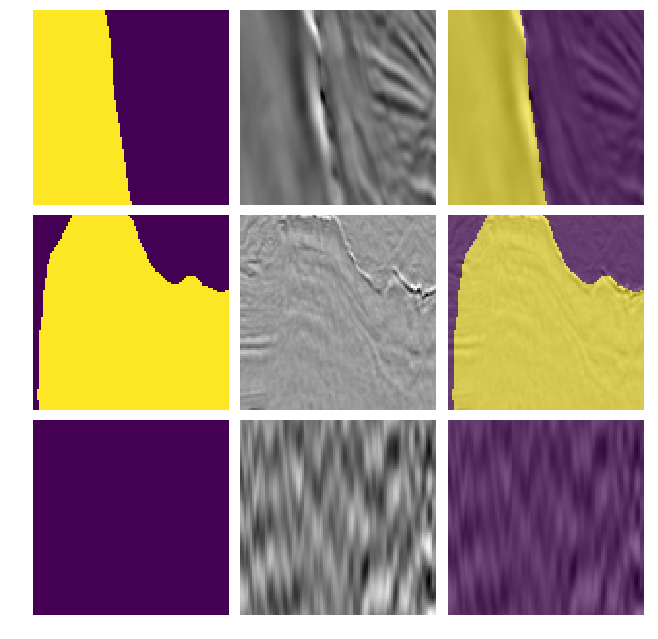

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt

nrows = pred.shape[0]


def draw_figures(aa, out_fig_name):
    
    nums = len(list(aa))

    plt.figure(figsize=(17, 3.5*nums))

    for i, index in enumerate(aa):
        # overlay two images
        plt.subplot(nums, 3, i*3+1)
        plt.imshow(pred[index])
        # 
        plt.axis('off')
        #
        plt.subplot(nums, 3, i*3+2)
        plt.imshow(image_samples[index], cmap='Greys')
        # 
        plt.axis('off')
        #
        plt.subplot(nums, 3, i*3+3)
        plt.imshow(pred[index])
        plt.imshow(image_samples[index], alpha=0.4, cmap='Greys')
        # 
        plt.axis('off')

    # plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.0, 
                        left=0.0, right=0.5, 
                        hspace=0.05, wspace=0.05)
    plt.savefig(out_fig_name)

#
aa = range(7, 12, 2)
#
draw_figures(aa, out_fig_name="tgs_kaggle_pred_img_1.png")

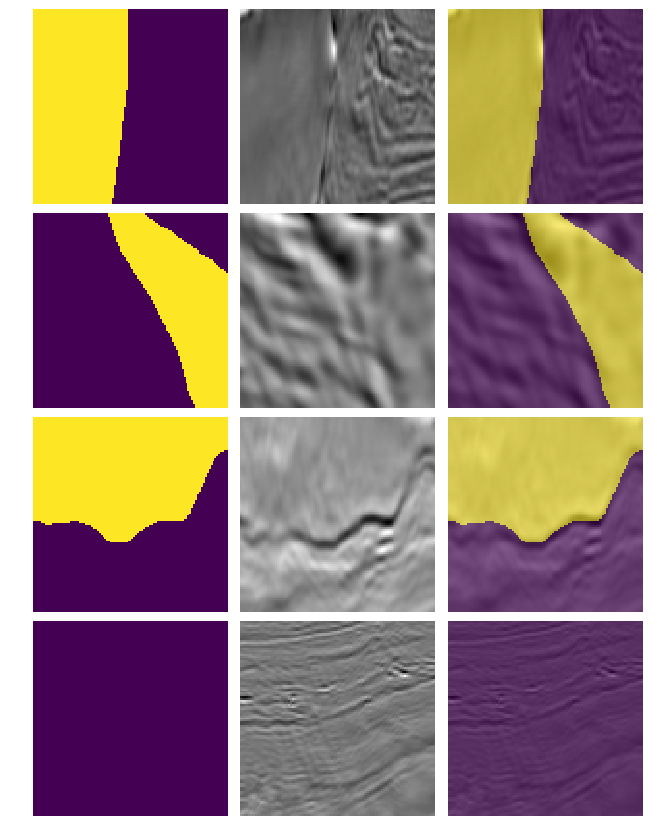

In [57]:
#
aa = [18, 24, 25, 26]
#
draw_figures(aa, out_fig_name="tgs_kaggle_pred_img_2.png")